# Text Classification

### Libraries

In [60]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import Perceptron
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import cross_validate
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

### Datasets

In [2]:
# load review sentiment data

review_df = pd.read_csv('review_sentiment.csv')

review_df

,review_id,text,positive,neutral,negative
0,NvusujU9_5pIUbn9SZ6hMA,Stopped by to munch a burger during today's Se...,1,0,0
1,vHOeBa7aMA_na4rfS2Db5A,"Yelp doesn't allow to leave 0 star review, so ...",0,0,1
2,hG9RTxxivb0ZXzEk4JXTXA,I find it hard to believe there are so many pe...,0,0,1
3,zIVkwgahZjOneChZFUYY4g,Love this place! Almost all of their menu item...,1,0,0
4,DLczAuvMAlAnY5EeDGhTVg,Excellent customer service. I wish I could ren...,1,0,0
...,...,...,...,...,...
63446,OgoBp7fbXnLSKvsQb4O_tw,"I really loved the food and service. I mean, t...",1,0,0
63447,Q7e8EtZMmdknDrQE7huMoQ,Their Grove location was the bomb. Delicious f...,1,0,0
63448,zzMW6zbsFaQMjoGu2bGVdA,A nice ean BBQ joint right across from some ne...,1,0,0
63449,scgoa60EvhW2Mz7JMqLYGw,The perfect Hookah bar. I'm not sure what they...,1,0,0


In [3]:
# load corpus data

corpus = open('corpus.txt', 'r').read()
corpus = corpus.split('\n')
corpus = corpus[:-1]

In [4]:
# see contents of corpus

for review in corpus[:5]:
    print('-' * 50)
    print(review)

--------------------------------------------------
stop munch burger today seahawk saint game place unsurprisingli pack good reason burger order fantast sat right next door get chanc get six feet place soon got meal place start get busier busier work way world shortest peopl maze get guess mean first person hear place go back might go say lunch tuesday less busi
--------------------------------------------------
yelp allow leav star review see one star wife move ny south california contact differ move compani sent initi email unit van line soon got email back virtual survey confirm ladi virtual survey meticul profession screen whole apart minut one contact sent second email almost month ask everyth ok get quot need mention compani sent quot less hour sinc one repli til today call direct phone left messag answer machin one call back hope everyth ok one hurt see reason explan avoid unprofession
--------------------------------------------------
find hard believ mani peopl low standard co

In [5]:
# load corpus data with stopwords

corpus_stopwords = open('corpus_stopwords.txt', 'r').read()
corpus_stopwords = corpus_stopwords.split('\n')
corpus_stopwords = corpus_stopwords[:-1]

In [6]:
# see contents of corpus with stopwords

for review in corpus_stopwords[:5]:
    print('-' * 50)
    print(review)

--------------------------------------------------
stop by to munch a burger dure today s seahawk saint game and the place wa unsurprisingli pack for good reason too the haven burger i order wa fantast i sat right next to the door so i didn t get the chanc to get more than six feet into the place as soon as i got my meal the place start get busier and busier until i had to work my way through the world s shortest peopl maze to get out guess that mean i wasn t the first person to hear about the place i will be go back to the haven might go for say lunch on a tuesday so it s less busi
--------------------------------------------------
yelp doesn t allow to leav star review so that is whi you see one star me and my wife are move from ny to south california and we contact differ move compani i sent my initi email to unit van line on and soon i got email back with virtual survey confirm for the ladi that did virtual survey wa veri meticul and profession and we screen through the whole apart

### Feature engineering

In [7]:
# vectorizers

bag_of_wors = CountVectorizer()
one_hot = CountVectorizer(binary=True)
n_grams = CountVectorizer(ngram_range=(1, 2), max_features=15000)
tf_idf = TfidfVectorizer()

In [8]:
# apply a vectorizer to the corpus (stopwords included if using N-grams, for negation tokens)

vectorizer = tf_idf

X = None
if vectorizer == n_grams:
    X = vectorizer.fit_transform(corpus_stopwords).toarray()
else:
    X = vectorizer.fit_transform(corpus).toarray()

X.shape

(63451, 31987)

### Classifier training

In [9]:
# target labels

y = review_df[['positive', 'neutral', 'negative']]

y.shape

(63451, 3)

In [10]:
# split data into training and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

print("\nLabel distribution in the training set:")
print(y_train.value_counts())

print("\nLabel distribution in the test set:")
print(y_test.value_counts())

(50760, 31987) (50760, 3)
(12691, 31987) (12691, 3)

Label distribution in the training set:
positive  neutral  negative
1         0        0           34162
0         0        1           11717
          1        0            4881
Name: count, dtype: int64

Label distribution in the test set:
positive  neutral  negative
1         0        0           8518
0         0        1           2942
          1        0           1231
Name: count, dtype: int64


In [ ]:
# TODO: deal with class imbalance

In [ ]:
'''

sampling_strategies = {
    'positive': RandomUnderSampler(random_state=42),
    'neutral': RandomOverSampler(random_state=42),
    'negative': None
}

X_train_resampled = {}
y_train_resampled = {}
for label, sampler in sampling_strategies.items():
    if sampler is not None:
        X_resampled, y_resampled = sampler.fit_resample(X_train, y_train[label])
    else:
        X_resampled, y_resampled = X_train, y_train[label]
    X_train_resampled[label] = X_resampled
    y_train_resampled[label] = y_resampled

X_train_resampled_combined = np.concatenate([X_train_resampled[label] for label in sampling_strategies.keys()])
y_train_resampled_combined = np.concatenate([y_train_resampled[label] for label in sampling_strategies.keys()])

print("Shape of resampled training data:", X_train_resampled_combined.shape, y_train_resampled_combined.shape)

'''

In [12]:
# classifiers

nayve_bayes = MultinomialNB()
logistic_regression = LogisticRegression(random_state=0)
decision_tree = DecisionTreeClassifier()
random_forest = RandomForestClassifier()
svm = SVC()
perceptron = Perceptron(tol=1e-3, random_state=0)
xgb = XGBClassifier()

In [13]:
# train a classifier

clf = MultiOutputClassifier(logistic_regression)

clf.fit(X_train, y_train)

MultiOutputClassifier(estimator=LogisticRegression(random_state=0))

In [57]:
# get predictions

y_pred_clf = clf.predict(X_test)
print(y_pred_clf)

[[0 0 0]
 [1 0 0]
 [1 0 0]
 ...
 [1 0 0]
 [1 0 0]
 [0 0 1]]


In [ ]:
# cross-validation

cv_scores = cross_validate(clf, X, y, scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'], cv=5)

# Memory Error popping up here (too much dimensionality???)

In [75]:
# VADER sentiment analysis

vader = SentimentIntensityAnalyzer()
res = []
y_pred_vader = []
for review in review_df['text']:
    sentiment = vader.polarity_scores(review)
    res.append(sentiment)
    stronger_value = max(sentiment['pos'], sentiment['neu'], sentiment['neg'])
    if sentiment['pos'] == stronger_value:
        y_pred_vader.append([1, 0, 0])
    elif sentiment['neu'] == stronger_value:
        y_pred_vader.append([0, 1, 0])
    elif sentiment['neg'] == stronger_value:
        y_pred_vader.append([0, 0, 1])
        
res

[{'neg': 0.031, 'neu': 0.914, 'pos': 0.055, 'compound': 0.594},
 {'neg': 0.104, 'neu': 0.86, 'pos': 0.035, 'compound': -0.906},
 {'neg': 0.056, 'neu': 0.846, 'pos': 0.097, 'compound': 0.9416},
 {'neg': 0.0, 'neu': 0.618, 'pos': 0.382, 'compound': 0.9647},
 {'neg': 0.0, 'neu': 0.675, 'pos': 0.325, 'compound': 0.9018},
 {'neg': 0.072, 'neu': 0.694, 'pos': 0.233, 'compound': 0.9161},
 {'neg': 0.017, 'neu': 0.846, 'pos': 0.137, 'compound': 0.8908},
 {'neg': 0.031, 'neu': 0.883, 'pos': 0.085, 'compound': 0.7678},
 {'neg': 0.1, 'neu': 0.834, 'pos': 0.066, 'compound': -0.9218},
 {'neg': 0.0, 'neu': 0.328, 'pos': 0.672, 'compound': 0.8481},
 {'neg': 0.0, 'neu': 0.851, 'pos': 0.149, 'compound': 0.7387},
 {'neg': 0.109, 'neu': 0.891, 'pos': 0.0, 'compound': -0.5994},
 {'neg': 0.006, 'neu': 0.855, 'pos': 0.138, 'compound': 0.9834},
 {'neg': 0.066, 'neu': 0.85, 'pos': 0.084, 'compound': -0.2001},
 {'neg': 0.08, 'neu': 0.783, 'pos': 0.137, 'compound': 0.8155},
 {'neg': 0.0, 'neu': 0.67, 'pos': 0.33

### Model performance

In [63]:
def evaluate_model(y_test, y_pred):
    '''
    Evaluate the performance of a multi-label classifier
    '''
    multilabel_cm = multilabel_confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    print("Multilabel Confusion Matrix:")
    print(multilabel_cm)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)

In [64]:
# performance metrics - classifier

evaluate_model(y_test, y_pred_clf)

Multilabel Confusion Matrix:
[[[ 3427   746]
  [  425  8093]]

 [[11359   101]
  [ 1111   120]]

 [[ 9402   347]
  [  621  2321]]]
Accuracy: 0.8235757623512725
Precision: 0.8688733619525079
Recall: 0.8300370341186668
F1-score: 0.8337530599336186


In [77]:
# performance metrics - VADER

y_true = review_df[['positive', 'neutral', 'negative']]
y_true = y_true.values

evaluate_model(y_true, y_pred_vader)

# Note: values are like this probably because of criteria applied when building y_pred_vader

Multilabel Confusion Matrix:
[[[20762     9]
  [41483  1197]]

 [[ 1215 56124]
  [    7  6105]]

 [[48791     1]
  [14644    15]]]
Accuracy: 0.11531733148413736
Precision: 0.8936647988230694
Recall: 0.11531733148413736
F1-score: 0.0543752976396964


In [80]:
# dataframe with VADER sentiment scores

vader_df = pd.DataFrame(res)
vader_df.columns = ['vader_neg', 'vader_neu', 'vader_pos', 'vader_compound']
vader_df = pd.concat([review_df, vader_df], axis=1)

vader_df

,review_id,text,positive,neutral,negative,vader_neg,vader_neu,vader_pos,vader_compound
0,NvusujU9_5pIUbn9SZ6hMA,Stopped by to munch a burger during today's Se...,1,0,0,0.031,0.914,0.055,0.5940
1,vHOeBa7aMA_na4rfS2Db5A,"Yelp doesn't allow to leave 0 star review, so ...",0,0,1,0.104,0.860,0.035,-0.9060
2,hG9RTxxivb0ZXzEk4JXTXA,I find it hard to believe there are so many pe...,0,0,1,0.056,0.846,0.097,0.9416
3,zIVkwgahZjOneChZFUYY4g,Love this place! Almost all of their menu item...,1,0,0,0.000,0.618,0.382,0.9647
4,DLczAuvMAlAnY5EeDGhTVg,Excellent customer service. I wish I could ren...,1,0,0,0.000,0.675,0.325,0.9018
...,...,...,...,...,...,...,...,...,...
63446,OgoBp7fbXnLSKvsQb4O_tw,"I really loved the food and service. I mean, t...",1,0,0,0.078,0.725,0.197,0.9729
63447,Q7e8EtZMmdknDrQE7huMoQ,Their Grove location was the bomb. Delicious f...,1,0,0,0.023,0.657,0.320,0.9955
63448,zzMW6zbsFaQMjoGu2bGVdA,A nice ean BBQ joint right across from some ne...,1,0,0,0.025,0.773,0.202,0.9890
63449,scgoa60EvhW2Mz7JMqLYGw,The perfect Hookah bar. I'm not sure what they...,1,0,0,0.041,0.756,0.203,0.9729


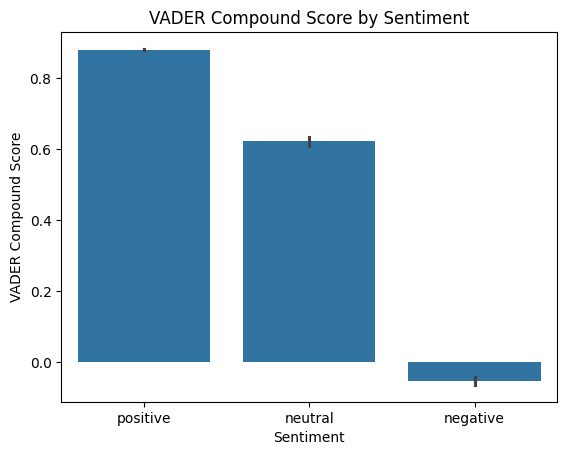

In [81]:
# visualize VADER compound scores by sentiment

positive_scores = vader_df[vader_df['positive'] == 1]['vader_compound']
neutral_scores = vader_df[vader_df['neutral'] == 1]['vader_compound']
negative_scores = vader_df[vader_df['negative'] == 1]['vader_compound']
all_scores = pd.concat([positive_scores, neutral_scores, negative_scores])

sentiments = ['positive'] * len(positive_scores) + ['neutral'] * len(neutral_scores) + ['negative'] * len(negative_scores)
sentiment_scores = pd.DataFrame({'sentiment': sentiments, 'vader_compound': all_scores})

sns.barplot(data=sentiment_scores, x='sentiment', y='vader_compound')
plt.xlabel('Sentiment')
plt.ylabel('VADER Compound Score')
plt.title('VADER Compound Score by Sentiment')
plt.show()

In [ ]:
# cross-validation results

cv_scores